In [111]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns # 另一個繪圖-樣式套件

from datetime import datetime

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

## Import all relative datasets: sales_train, test, items, item_categories, shopa

In [2]:
sales_train = pd.read_csv('./data/sales_train.csv')
test = pd.read_csv('./data/test.csv') 
items = pd.read_csv('./data/items.csv')
items_cat = pd.read_csv('./data/item_categories.csv')
shops = pd.read_csv('./data/shops.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

# 1. EDA
### The dataset shops contained two columns(shop_name(str) & shop_id(int64)). There are 60 unique shop_id and no missing values.
### The dataset items contained three columns(item_name(str) & item_id(int64) & item_category_id(int64)). There are 22170 unique item_id and no missing values.
### The dataset items_cat contained three columns(item_category_name(str) & item_category_id(int64) & item_category_id(int64)). There are 84 unique item_category_id and no missing values.

In [3]:
print(f'shops\n columns: {shops.columns.values}\n\
     nuniuque: {shops.shop_id.nunique()}\n\
     missing: {shops.isna().sum().to_dict()}')
print(f'items\n columns: {items.columns.values}\n\
     nuniuque: {items.item_id.nunique()}\n\
     missing: {items.isna().sum().to_dict()}')
print(f'items_cat\n columns: {items_cat.columns.values}\n\
     nuniuque: {items_cat.item_category_id.nunique()}\n\
     missing: {items_cat.isna().sum().to_dict()}')

shops
 columns: ['shop_name' 'shop_id']
     nuniuque: 60
     missing: {'shop_name': 0, 'shop_id': 0}
items
 columns: ['item_name' 'item_id' 'item_category_id']
     nuniuque: 22170
     missing: {'item_name': 0, 'item_id': 0, 'item_category_id': 0}
items_cat
 columns: ['item_category_name' 'item_category_id']
     nuniuque: 84
     missing: {'item_category_name': 0, 'item_category_id': 0}


### In the salse_train, there are 60 unique shop id and 21807 unique item id. All of them are in the shops and items.

In [4]:
print('Sales Train')
print('shop id')
print(sales_train.shop_id.nunique())
print(sales_train[-sales_train.shop_id.isin(shops.shop_id)])
print('===========================================================')
print('item id')
print(sales_train.item_id.nunique())
print(sales_train[-sales_train.item_id.isin(items.item_id)])


Sales Train
shop id
60
Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []
item id
21807
Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []


### In the Test, there are 42 unique shop id and 5100 unique item id. All of them are in the shops and items.

In [5]:
print('Test')
print('shop id')
print(test.shop_id.nunique())
print(test[-test.shop_id.isin(shops.shop_id)])
print('===========================================================')
print('item id')
print(test.item_id.nunique())
print(test[-test.item_id.isin(items.item_id)])

Test
shop id
42
Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []
item id
5100
Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []


### We combine shop_id and item_id into shopitem_id. In the sales_train, there are 424124 unique shopitem_id. In the test, ther 214200 unique shopitem_id. The number in sales_train is bigger than in test. However, there are 111404 unique shopitem_id in test but not in sales_train.
### For these shopitem_id that in test but not in sales_train, because we do not have their historical sales record, we could predict 0 sales in the future in the first vision.

In [6]:
sales_train['shopitem_id'] = list(zip(sales_train.shop_id, sales_train.item_id))
test['shopitem_id'] = list(zip(test.shop_id, test.item_id))
print('shopitem_id')
print(f'sales_train: {len(sales_train.shopitem_id.unique())}')
print(f'test: {len(test.shopitem_id.unique())}')
num_notintrain = test[-test['shopitem_id'].isin(sales_train['shopitem_id'])].shape[0]
print(f'There are {num_notintrain} shopitem_id in test but not in sales_train')

shopitem_id
sales_train: 424124
test: 214200
There are 102796 shopitem_id in test but not in sales_train


## a. Shops
### In the shops, we found that there are more information in the columns "shop_name". Using google help, the fisrt word in the shop_name is city name and the second word is the type of shop

In [7]:
shops['city'] = shops.shop_name.apply(lambda x: x.split(' ')[0])
shops['shop_type'] = shops.shop_name.apply(lambda x: x.split(' ')[1])
print(shops['shop_type'].unique())
shop_types = {
    'Орджоникидзе,':'others',
    '\(Плехановская,':'others',
    '"Распродажа"':'others',
    'Посад':'others'
}
shops['shop_type'] = shops['shop_type'].replace(regex = shop_types)

['Орджоникидзе,' 'ТЦ' 'ТРК' 'ТРЦ' '(Плехановская,' 'Торговля' 'ул.' 'ЧС'
 '"Распродажа"' 'МТРЦ' 'Магазин' 'ТК' 'Посад' 'склад']


In [8]:
# shops

### At the meanwhile, some people said ther are some mistakes in the shopname, so we adjust them. 

In [9]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# shops

In [10]:
test.sort_values(by='shop_id').shop_id.unique()

array([ 2,  3,  4,  5,  6,  7, 11, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)

In [11]:
sales_train['shopitem_id'] = list(zip(sales_train.shop_id, sales_train.item_id))
test['shopitem_id'] = list(zip(test.shop_id, test.item_id))
print('shopitem_id')
print(f'sales_train: {len(sales_train.shopitem_id.unique())}')
print(f'test: {len(test.shopitem_id.unique())}')
num_notintrain = test[-test['shopitem_id'].isin(sales_train['shopitem_id'])].shape[0]
print(f'There are {num_notintrain} shopitem_id in test but not in sales_train')

shopitem_id
sales_train: 418909
test: 214200
There are 102729 shopitem_id in test but not in sales_train


## b. items_cat
### In the items_cat, we found that there are some similiar words in the begining of item_category_name. We set them as a big class.

In [12]:
items_cat['subdept'] = items_cat.item_category_name.apply(lambda x:x.split(' ')[0])
# items_cat['subdept'].unique()

## c. Outliers

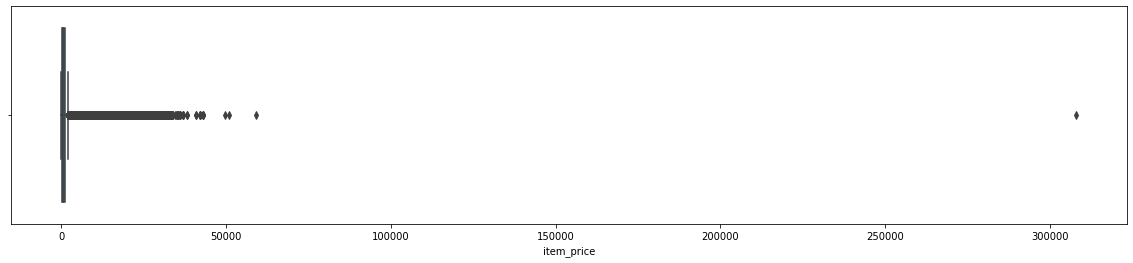

In [13]:
plt.subplots(1,figsize=(20,4))
sns.boxplot(x='item_price',data=sales_train)
# plt.xlim(-10,10000)
plt.show()

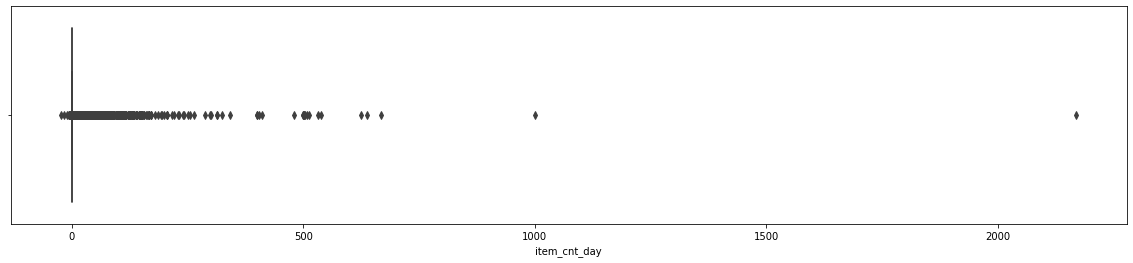

In [14]:
plt.subplots(1,figsize=(20,4))
sns.boxplot(x='item_cnt_day',data=sales_train)
plt.show()

In [15]:
replace_mean_price = sales_train.loc[((sales_train.shopitem_id==(32, 2973)) & (sales_train.item_price>=0)),'item_price'].mean()
sales_train.loc[((sales_train.shopitem_id==(32, 2973)) & (sales_train.item_price<0)),'item_price'] = replace_mean_price

sales_train = sales_train[sales_train.item_price<300000]
sales_train = sales_train[sales_train.item_cnt_day<1500]

## d. Time feature

In [16]:
sales_train.date = sales_train.date.apply(lambda x:datetime.strptime(x,"%d.%m.%Y"))
sales_train['year_month'] = sales_train.date.apply(lambda x:x.strftime("%Y-%m"))

## e. Another feature

In [17]:
sales_train['sales'] = sales_train['item_price'] * sales_train['item_cnt_day']

## f. Plot

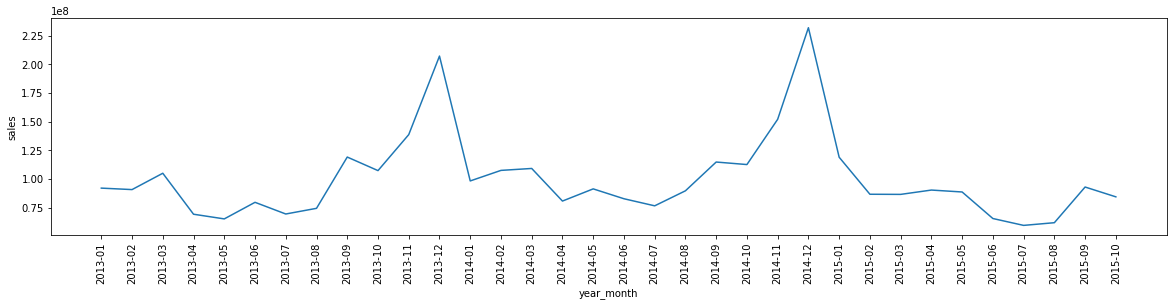

In [18]:
sales_monthly = sales_train.groupby(['year_month'])['sales'].sum().reset_index()
plt.subplots(1,figsize=(20,4))
sns.lineplot(x='year_month', y='sales', data=sales_monthly)
plt.xticks(rotation=90)
plt.show()

# 2. Modle

## a. Divide

In [19]:
no_sales = test[-test.shopitem_id.isin(sales_train.shopitem_id)]['shopitem_id'].values

In [149]:
train = sales_train.groupby(['shopitem_id','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')
train_table = pd.pivot_table(train,values='item_cnt_month',index='shopitem_id',columns='date_block_num',fill_value=0)

In [150]:
train_table = train_table.loc[:,range(33,-1,-1)]
train_table = train_table.reset_index()

In [151]:
train_table['12M_0'] = (train_table.loc[:,range(32,20,-1)].sum(axis=1) == 0)

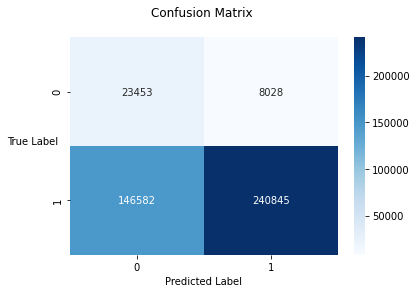

In [152]:
y_real = train_table[33] == 0
cnf_matrix = metrics.confusion_matrix(y_real, train_table['12M_0'])
sns.heatmap(cnf_matrix,cmap = plt.cm.Blues, annot=True, fmt="d")
plt.ylabel('True Label',rotation=0, labelpad=20)
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix \n')
plt.show()

In [153]:
data = train_table[-train_table['12M_0']].reset_index(drop=True)

In [154]:
train_y = data[33] - data[21]
train_X = data.loc[:,range(32,20,-1)].values - data.loc[:,range(20,8,-1)].values

In [187]:
z_score = StandardScaler()
z_score.fit(train_X)
train_X = z_score.transform(train_X)

In [156]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=12)

In [166]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [167]:
model01 = RandomForestRegressor()
model01.fit(X = x_train, y = y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [168]:
y_test_pred = model01.predict(x_test)

In [169]:
def kpi(y_true, y_pred, reg=True):
        if reg:
            r2 = metrics.r2_score(y_true, y_pred)
            mse = metrics.mean_squared_error(y_true, y_pred)
            mae = metrics.mean_absolute_error(y_true, y_pred)
            print('r2:{:.2f}, mse:{:,.2f}, mae:{:,.2f}'.format(r2, mse, mae))

In [170]:
kpi(y_true=y_test, y_pred=y_test_pred)

r2:0.61, mse:16.01, mae:0.42


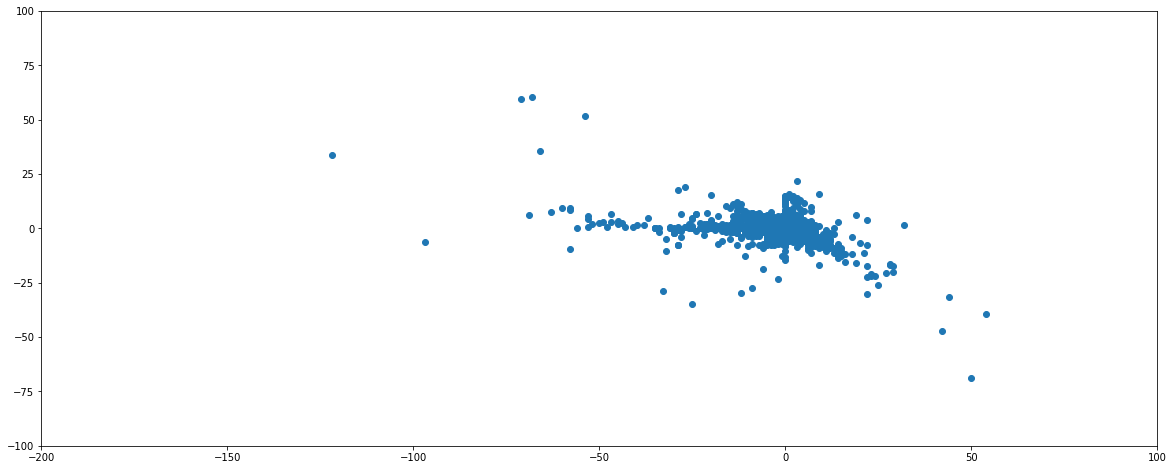

In [176]:
error = y_test_pred - y_test
plt.subplots(1,figsize=(20,8))
plt.scatter(y_test, error)
plt.xlim([-200,100])
plt.ylim([-100,100])
plt.show()

In [177]:
model_final = RandomForestRegressor()
model_final.fit(X = train_X, y = train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# 3. Submit Data

In [236]:
test_table = pd.merge(test,train_table)

In [184]:
test_table['12M_0'] = (test_table.loc[:,range(33,21,-1)].sum(axis=1) == 0)
test_table = test_table[-test_table['12M_0']].reset_index(drop=True)

In [189]:
test_table_ID = test_table.ID
test_X = test_table.loc[:,range(33,21,-1)].values - test_table.loc[:,range(21,9,-1)].values
test_X = z_score.transform(test_X)

In [193]:
test_y_pred = model_final.predict(test_X)

In [196]:
test_y = test_table[22] + test_y_pred

In [200]:
test_y[test_y<0] = 0

In [208]:
submit = pd.DataFrame({'ID':test_table_ID,'item_cnt_month':test_y})

In [215]:
submit = pd.merge(test,submit,how='left').fillna(0).loc[:,['ID','item_cnt_month']]

In [217]:
submit.to_csv('./submit/submit_20210815_01.csv',index=0)

In [248]:
submit = sample_submission.copy()

In [249]:
submit.loc[test['shopitem_id'].isin(pd.Series(no_sales)),'item_cnt_month']=0

In [250]:
submit

,ID,item_cnt_month
0,0,0.5
1,1,0.0
2,2,0.5
3,3,0.5
4,4,0.0
...,...,...
214195,214195,0.5
214196,214196,0.0
214197,214197,0.5
214198,214198,0.0


In [232]:
submit.to_csv('./submit/submit_20210815_02.csv',index=0)

In [237]:
test_table['12M_0'] = (test_table.loc[:,range(33,21,-1)].sum(axis=1) == 0)

In [239]:
test_table['12M_0'].sum()

16761

In [257]:
submit.loc[submit.ID.isin(test_table.loc[test_table['12M_0'],'ID']),'item_cnt_month']=0

In [260]:
submit.to_csv('./submit/submit_20210815_03.csv',index=0)

In [38]:
sales_train_filter = pd.merge(sales_train,test,on=['shop_id','item_id'])
sales_train_filter = sales_train_filter.groupby(['ID','date_block_num'])['item_cnt_day'].sum().reset_index(name = 'item_cnt_month').sort_values(by=['ID','date_block_num'])

sales_train_filter = sales_train_filter[sales_train_filter.date_block_num.isin(list(range(22,34)))]
sales_train_predict = (sales_train_filter.groupby(['ID'])['item_cnt_month'].sum()/12).reset_index()
sales_train_predict = pd.merge(test,sales_train_predict,how = 'left')
sales_train_predict.item_cnt_month.fillna(0,inplace = True)
submmit = sales_train_predict.drop(['shop_id','item_id'],axis=1)

In [67]:
submmit.to_csv('./submit/submit_20210726_01.csv',index=0)

In [72]:
sales_train_filter = pd.merge(sales_train,test,on=['shop_id','item_id'])
sales_train_filter = sales_train_filter.groupby(['ID','date_block_num'])['item_cnt_day'].sum().reset_index(name = 'item_cnt_month').sort_values(by=['ID','date_block_num'])


In [98]:
df01 = pd.DataFrame({'ID':sales_train_filter.ID.unique().repeat(34),'date_block_num':list(range(34))*sales_train_filter.ID.nunique()})

In [100]:
df01 = pd.merge(df01, sales_train_filter, how = 'left')

In [102]:
df01.item_cnt_month.fillna(0,inplace=True)

In [120]:
id_index = iter(list(range(100)))

(0.0, 4.0)

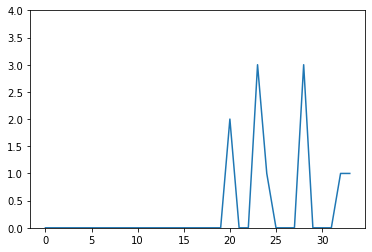

In [109]:
id_index = 5
plt.plot(df01[df01.ID==id_index]['date_block_num'],
         df01[df01.ID==id_index]['item_cnt_month'])
plt.ylim([0,4])